In [1]:
import re
import os
import sys
import pickle
sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

# os.chdir(current_dir_path + '\\ultils')
os.chdir(current_dir_path + '/ultils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.font_manager import FontProperties
import seaborn as sns

from sklearn.utils import resample
from sklearn.cluster import AgglomerativeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

from utils_v3 import *
from functions import *

myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
sns.set(style="whitegrid", font=myfont.get_name())

os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
# os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 同時保留大小類別可能是冗長的
    # 小類別
    # '道路型態子類別名稱', '事故位置子類別名稱',
    # '車道劃分設施-分向設施子類別名稱', 
    # '事故類型及型態子類別名稱', '肇因研判子類別名稱-主要', '當事者區分-類別-子類別名稱-車種', '當事者行動狀態子類別名稱',
    # '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別', 

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '肇因研判大類別名稱-主要', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別',
]

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

In [4]:
sampling_ratio = 0.5

# 計算 A1 和 A2 原始數據量比例
A1_total = len(dist_dfA1)
A2_total = len(dist_dfA2)
total_ratio = A1_total / A2_total  # 保留 A1/A2 的比例

# 定義函數，按月份進行下採樣
def downsample_by_month_simple(A1, A2, sampling_ratio, total_ratio):
    A1_downsampled = pd.DataFrame()
    A2_downsampled = pd.DataFrame()

    months = sorted(set(A1['發生月份']).intersection(A2['發生月份']))  # 確保月份匹配

    for month in months:
        # 提取該月份的資料
        A1_month = A1[A1['發生月份'] == month]
        A2_month = A2[A2['發生月份'] == month]

        # 計算該月份目標數量
        A1_target = int(len(A1_month) * sampling_ratio)
        A2_target = int(A1_target / total_ratio)
        print(A1_target)
        print(A2_target)

        # 下採樣
        A1_sampled = resample(A1_month, replace=False, n_samples=A1_target, random_state=42)
        A2_sampled = resample(A2_month, replace=False, n_samples=A2_target, random_state=42)

        # 合併到最終結果
        A1_downsampled = pd.concat([A1_downsampled, A1_sampled])
        A2_downsampled = pd.concat([A2_downsampled, A2_sampled])

    return A1_downsampled.reset_index(drop=True), A2_downsampled.reset_index(drop=True)

# 下採樣
downsampled_A1, downsampled_A2 = downsample_by_month_simple(dist_dfA1, dist_dfA2, sampling_ratio, total_ratio)

# 檢查結果
print(f"下採樣前 A1 資料量：{len(dist_dfA1)} / 下採樣後 A1 資料量：{len(downsampled_A1)}")
print(f"下採樣前 A1 資料量：{len(dist_dfA2)} / 下採樣後 A2 資料量： {len(downsampled_A2)}")
print("舊 A1/A2 比例：", len(dist_dfA1) / len(dist_dfA2))
print("新 A1/A2 比例：", len(downsampled_A1) / len(downsampled_A2))

# Concat
rbind_data = pd.concat([downsampled_A1, downsampled_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

74
16962
79
18109
67
15358
56
12836
60
13753
64
14670
75
17192
71
16275
65
14899
78
17879
下採樣前 A1 資料量：1383 / 下採樣後 A1 資料量：689
下採樣前 A1 資料量：317023 / 下採樣後 A2 資料量： 157933
舊 A1/A2 比例： 0.004362459506092618
新 A1/A2 比例： 0.004362609460973958


In [5]:
bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

dummy_data: (158622, 174)


In [6]:
with open('/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid_halfdata.pkl', 'rb') as f:
    detailed_results_df = pickle.load(f)

# detailed_results_df = detailed_results_df.sort_values(by='silhouette')
# detailed_results_df

In [35]:
class MapperPlotter:
    def __init__(self, mapper_info, rbind_data, detailed_results_df, cmap='jet', seed=10, width=400, height=400):
        self.mapper_info = mapper_info
        self.rbind_data = rbind_data
        self.detailed_results_df = detailed_results_df
        self.cmap = cmap
        self.seed = seed
        self.width = width
        self.height = height
        self.mapper_plot = None
        self.full_info = None

    def create_mapper_plot(self, choose, common_encoded_label):
        self.rbind_data['color_for_plot'] = pd.factorize(self.rbind_data[choose])[0]
        self.mapper_plot = MapperLayoutInteractive(
            self.mapper_info,
            colors=self.rbind_data['color_for_plot'].to_numpy(),
            cmap=self.cmap,
            agg=common_encoded_label,
            dim=2,
            iterations=30,
            seed=self.seed,
            width=self.width,
            height=self.height
        )
        print("Mapper plot created.")

    def extract_data(self):
        x = vars(self.mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
        y = vars(self.mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
        threeDimData = pd.DataFrame({'x': x, 'y': y})
        
        data_tuple = vars(self.mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['text']
        data = []
        for item in data_tuple:
            color = float(re.search(r'color: ([\d.]+)', item).group(1))
            node = int(re.search(r'node: (\d+)', item).group(1))
            size = int(re.search(r'size: (\d+)', item).group(1))
            data.append({'color': color, 'node': node, 'size': size})
        component_info = pd.DataFrame(data)
        
        self.full_info = pd.concat([component_info, threeDimData], axis=1)
        mp_content_origin = vars(self.mapper_plot._MapperLayoutInteractive__graph)['_node']
        mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index').reset_index()
        mp_content.rename(columns={'index': 'node'}, inplace=True)
        
        self.full_info = pd.merge(self.full_info, mp_content, on=['node', 'size'], how='inner')
        print("Data extracted.")

    def map_colors(self, choose, color_mapping_fixed):
        # df = self.full_info[(self.full_info['size'] > 20)]
        df = self.full_info
        unique_values = self.rbind_data[[choose, 'color_for_plot']].drop_duplicates()
        df = df.merge(unique_values, left_on='color', right_on='color_for_plot', how='left')

        # 使用外部提供的顏色映射表
        df['color_for_plot_fixed'] = df[choose].map(color_mapping_fixed)
        
        self.full_info = df
        self.color_palette = color_mapping_fixed
        print("Colors mapped using predefined mapping.")

    def plot(self, choose, unique_categories, color_palette, avg=None, save_path=None, set_label=False):
        myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
        clipped_size = np.clip(self.full_info['size'], None, 200)
        # clipped_size = self.full_info['size']

        plt.figure(figsize=(15, 12))

        if avg:
            color=self.full_info['color']
        else:
            color=self.full_info['color_for_plot_fixed'].tolist()

        scatter = plt.scatter(
            self.full_info['x'], self.full_info['y'],
            c=color,
            edgecolors='black',
            linewidths=0.5,
            s=clipped_size,
            marker='o',
            alpha=0.7
        )

        node_positions = {row['node']: (row['x'], row['y']) for _, row in self.full_info.iterrows()}
        graph = vars(self.mapper_plot._MapperLayoutInteractive__graph)
        edges = graph['edges']
        for edge in edges:
            if edge[0] in node_positions and edge[1] in node_positions:
                x_coords = [node_positions[edge[0]][0], node_positions[edge[1]][0]]
                y_coords = [node_positions[edge[0]][1], node_positions[edge[1]][1]]
                plt.plot(x_coords, y_coords, color='grey', alpha=0.5, linewidth=0.5, zorder=0)

        if set_label:
            
            if avg:
                colorbar = plt.colorbar(scatter, ax=plt.gca(), orientation='vertical', pad=0.02)
                colorbar.set_label(f'{choose}', fontproperties=myfont)
            else:
                handles = [
                    plt.Line2D(
                        [0], [0],
                        marker='o',
                        color=color_palette(i),
                        markersize=10,
                        label=name
                    ) for i, name in enumerate(unique_categories)
                ]
                plt.legend(handles=handles, title=f"{choose}", loc='upper right', bbox_to_anchor=(1.2, 1))

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Mapper plot')
        plt.grid(True)

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {save_path}")
        else:
            plt.show()

In [36]:
choose = '肇因研判大類別名稱-個別'

unique_categories = rbind_data[choose].dropna().unique()
unique_categories.sort()

# 統一顏色
color_palette = get_cmap("tab20", len(unique_categories))
color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}


/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_67592/1643206544.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Mapper plot created.
Data extracted.
Colors mapped using predefined mapping.


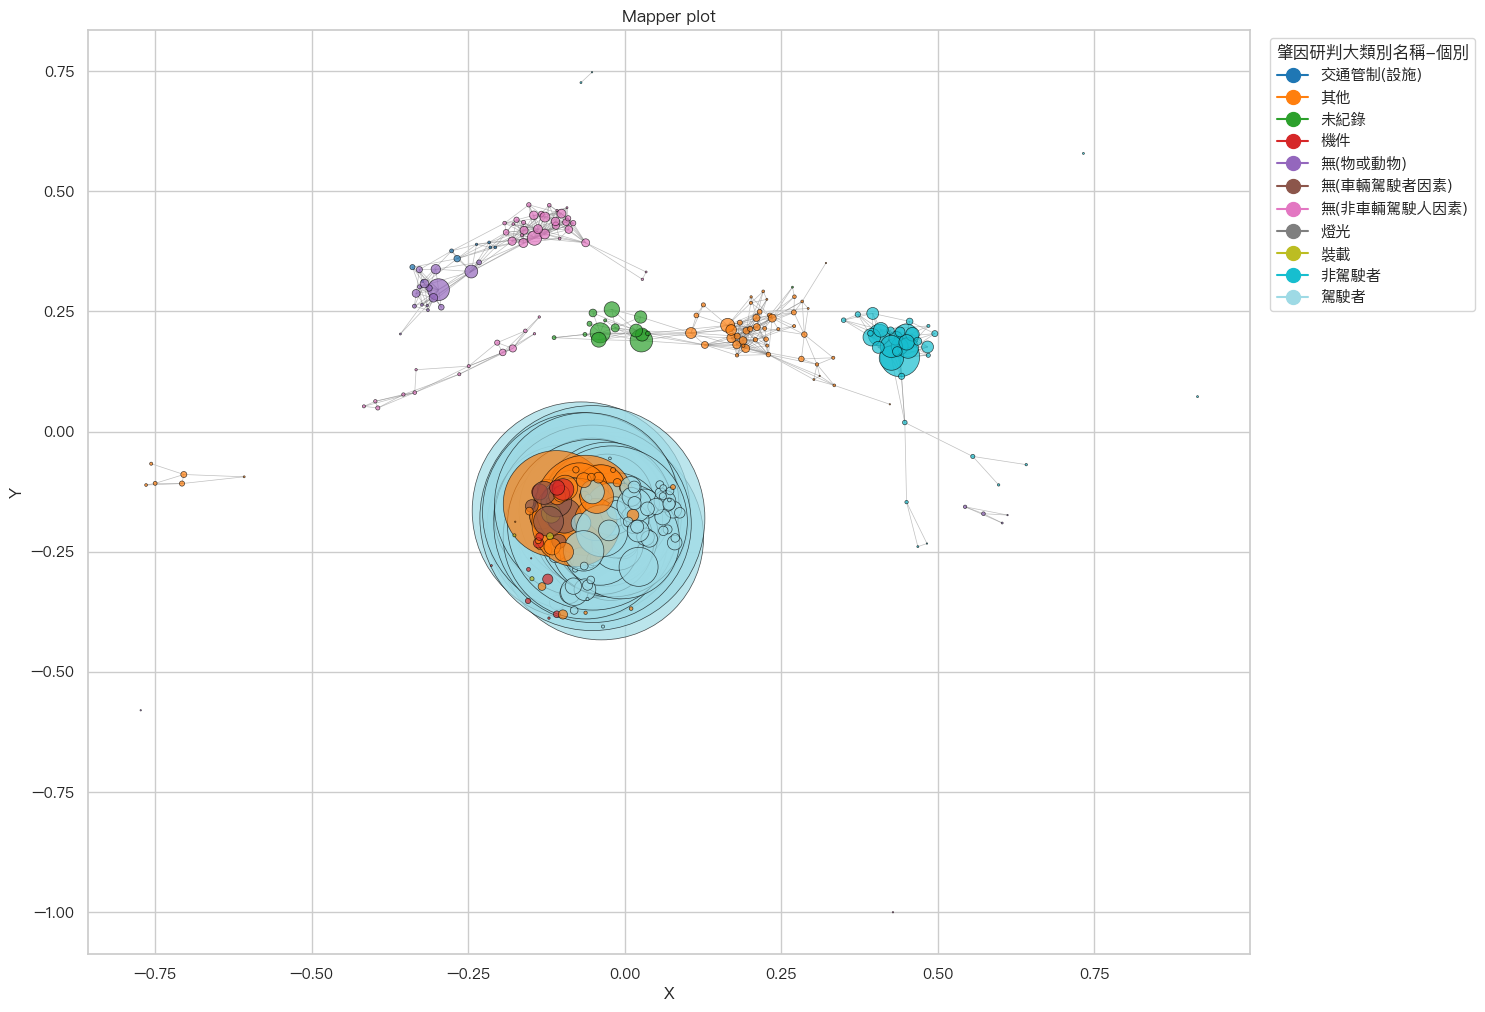

In [37]:
mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[1][0], rbind_data, detailed_results_df)
mapper_plotter.create_mapper_plot(choose, most_common_encoded_label)
mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, color_mapping_fixed)
mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, set_label=True)

Mapper plot created.
Data extracted.
Colors mapped using predefined mapping.


/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_57684/3924303669.py:54: UserWarning:

You are merging on int and float columns where the float values are not equal to their int representation.



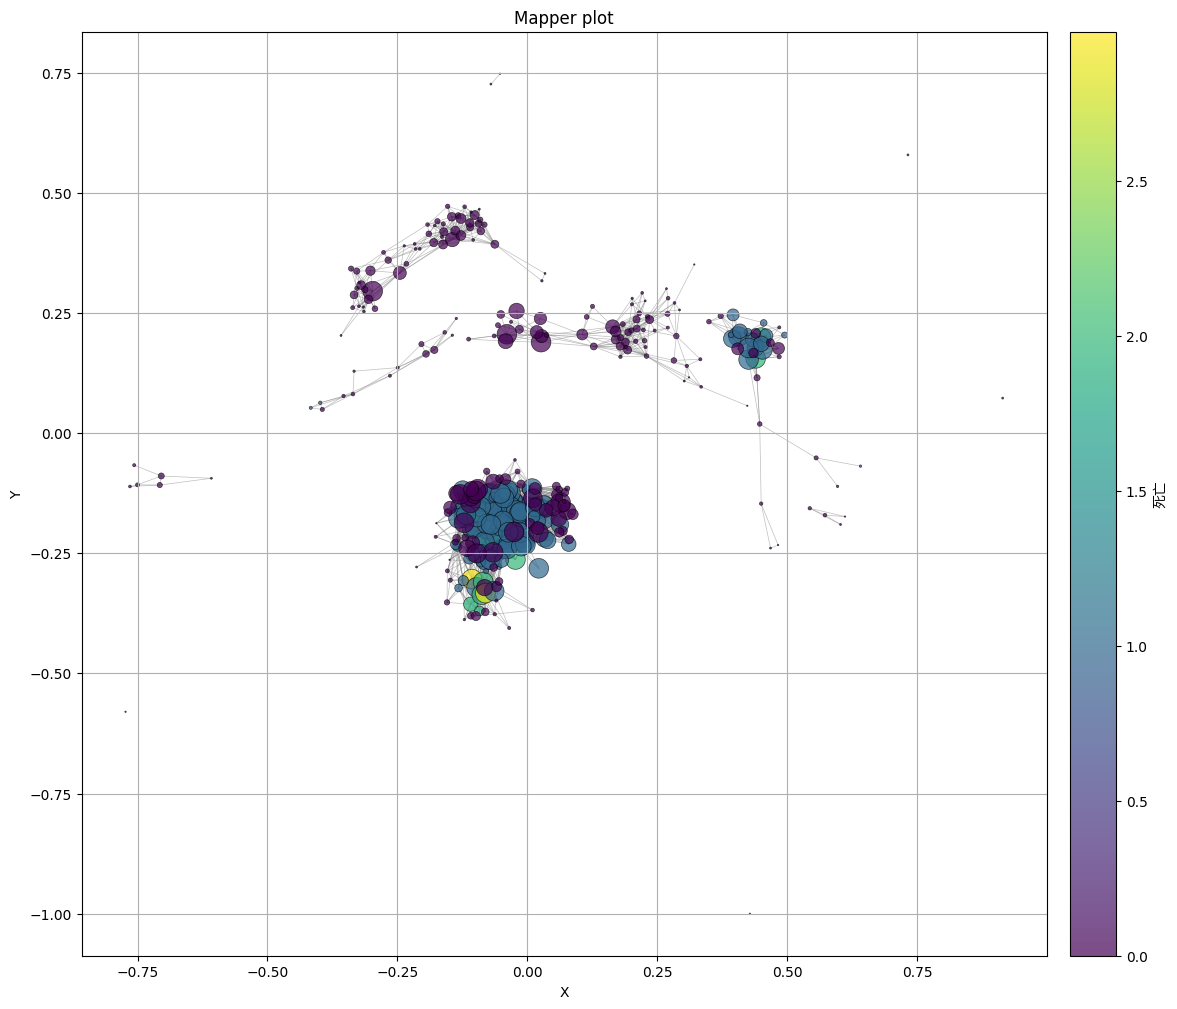

In [28]:
mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[1][0], rbind_data, detailed_results_df)
mapper_plotter.create_mapper_plot(choose, average_encoded_label)
mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, color_mapping_fixed)
mapper_plotter.plot(choose, unique_categories, color_palette, avg=True)

In [ ]:
for i in range(detailed_results_df.shape[0]):

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[i][0], rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, color_mapping_fixed)

    o = detailed_results_df['overlap'].iloc[i]
    i = detailed_results_df['interval'].iloc[i]
    mapper_plotter.plot(choose, unique_categories, color_palette, save_path=f'Version3/GridSearch/Plots/plot_o{o}i{i}.png')
    # mapper_plotter.plot(choose, unique_categories, color_palette)